# Trading Strategy Design (Continue)
Previous strategy (v3 stable) has positive returns but the portfolio over time mimic the BTC price over time, and the sharpe ratio is low. So, though the strategy is functional, the earning may not bring by the strategy itself. This strategy training is aimed to make a strategy that let profit runs and take more risks.

In [1]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append('/Users/zway/Desktop/BTC_Project/Crypto_Research/features')
from trend_indicator_pipeline_pkg import MovingAveragePipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline

from arcticdb.version_store.helper import ArcticMemoryConfig

from arcticdb import Arctic

In [2]:
# Load files
df = pd.read_csv('/Users/zway/Desktop/BTC_Project/raw_datasets/BTCUSD_1m_2023.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# DB path
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

In [3]:
# indicators simplify
trend = MovingAveragePipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
momentum = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
volatility = VolatilityIndicatorPipeline(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")

20250707 03:43:08.849185 16817471 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[27816]
20250707 03:43:08.850428 16817471 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[27816]


In [4]:
# Set up indicators

# EMA
df = trend.compute_ema(df, days = 7)
df = trend.compute_ema(df, days = 20)
df = trend.compute_ema(df, days = 30)

# SMA
df = trend.compute_sma(df, days = 7)
df = trend.compute_sma(df, days = 20)
df = trend.compute_sma(df, days = 30)

# MACD - Standard: fast_days=12, slow_days=26, signal_days=9
df = momentum.compute_macd(df, 12, 26, 9)
df.rename(columns={
    'macd': 'macd_12_26',
    'macd_signal': 'macd_sig_12_26',
    'macd_diff': 'macd_hist_12_26'
}, inplace=True)

# RSI
df = momentum.compute_rsi(df, days=14)

# Bollinger Bands
df = volatility.compute_bollinger_bands(df, days=20, std=2)

In [13]:
# result summary & visualization helper tools
def summarize_portfolio(df, signals, initial_cash=10000, periods_per_year=252):
    final_value = df['portfolio_value'].iloc[-1]
    returns = df['portfolio_value'].pct_change().dropna()

    # Basic stats
    profit = final_value - initial_cash
    total_return = profit / initial_cash
    n_trades = len([s for s in signals if s[1] == 'Buy'])

    # Win rate
    profits = []
    in_trade = False
    for i, (ts, action, price) in enumerate(signals):
        if action == 'Buy':
            entry = price
            in_trade = True
        elif action == 'Sell' and in_trade:
            profits.append(price - entry)
            in_trade = False
    win_rate = np.mean([p > 0 for p in profits]) if profits else np.nan

    # Sharpe ratio
    sharpe = (returns.mean() / returns.std()) * np.sqrt(periods_per_year) if not returns.empty else np.nan

    # Max drawdown
    peak = df['portfolio_value'].cummax()
    drawdown = (df['portfolio_value'] - peak) / peak
    max_drawdown = drawdown.min()

    # Display
    summary = {
        'Initial Capital': f'${initial_cash:,.2f}',
        'Final Portfolio Value': f'${final_value:,.2f}',
        'Net Profit': f'${profit:,.2f}',
        'Total Return': f'{total_return:.2%}',
        'Number of Trades': n_trades,
        'Win Rate': f'{win_rate:.2%}' if not np.isnan(win_rate) else 'N/A',
        'Max Drawdown': f'{max_drawdown:.2%}' if not np.isnan(max_drawdown) else 'N/A',
        'Sharpe Ratio': f'{sharpe:.2f}' if not np.isnan(sharpe) else 'N/A'
    }

    for k, v in summary.items():
        print(f'{k:25s}: {v}')


def plot_full_strategy(df, signals, title='BTC/USD Aggressive-2 Strategy'):
    df = df.copy()
    buy_signals = [s for s in signals if s[1] == 'Buy']
    sell_signals = [s for s in signals if s[1] == 'Sell']

    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]})

    # ---- 1. Price + Portfolio + Buy/Sell ----
    ax = axes[0]
    ax.plot(df.index, df['Close'], label='BTC Price', color='orange', alpha=0.6)
    ax.plot(df.index, df['portfolio_value'], label='Portfolio Value', color='blue')
    ax.plot(df.index, df['ema_7d'], label='EMA 7d', linestyle='--', color='green')
    ax.plot(df.index, df['sma_7d'], label='SMA 7d', linestyle='--', color='purple')
    ax.plot(df.index, df['ema_30d'], label = 'EMA 30d', linestyle='--', color='pink')
    ax.plot(df.index, df['bb_upper_20d'], label='Bollinger Upper', linestyle=':', color='gray')

    for ts, action, price in buy_signals:
        if ts in df.index:
            ax.scatter(ts, price, marker='^', color='green', s=80, label='Buy Signal')
    for ts, action, price in sell_signals:
        if ts in df.index:
            ax.scatter(ts, price, marker='v', color='red', s=80, label='Sell Signal')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_title(title)
    ax.set_ylabel('USD')
    ax.grid(True)

    # ---- 2. MACD Histogram ----
    axes[1].bar(df.index, df['macd_hist_12_26'], label='MACD Histogram', color='gray')
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].legend()
    axes[1].set_ylabel('MACD Hist')
    axes[1].grid(True)

    # ---- 3. RSI ----
    axes[2].plot(df.index, df['rsi_14d'], label='RSI 14d', color='brown')
    axes[2].axhline(70, color='red', linestyle='--')
    axes[2].axhline(30, color='green', linestyle='--')
    axes[2].axhline(50, color='black', linestyle=':')
    axes[2].legend()
    axes[2].set_ylabel('RSI')
    axes[2].grid(True)

    # ---- 4. Portfolio Value Only ----
    axes[3].plot(df.index, df['portfolio_value'], label='Portfolio Value', color='blue')
    axes[3].legend()
    axes[3].set_ylabel('USD')
    axes[3].set_xlabel('Date')
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()


In [6]:
df

,Unnamed: 0,Open,High,Low,Close,Volume,ema_20d,sma_20d,macd_12_26,macd_sig_12_26,macd_hist_12_26,rsi_14d,bb_mid_20d,bb_upper_20d,bb_lower_20d
Timestamp,,,,,,,,,,,,,,,
2023-01-01 14:00:00,0,16474.3,16475.3,16473.1,16475.3,8.800000e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 14:01:00,1,16475.1,16477.7,16474.7,16476.8,8.600000e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 14:02:00,2,16477.3,16478.2,16476.4,16477.1,8.600000e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 14:03:00,3,16476.9,16478.5,16476.1,16478.2,9.200000e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 14:04:00,4,16477.6,16478.9,16477.0,16478.2,7.000000e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:23:00,484635,42419.1,42429.2,42419.1,42429.2,3.040000e-05,42321.817691,42625.787653,726.881256,1076.536923,-349.655668,50.105381,42625.787653,44320.470926,40931.104380
2023-12-31 14:24:00,484636,42429.5,42433.5,42428.5,42428.5,6.000000e-06,42321.825099,42625.735649,726.828828,1076.482960,-349.654132,50.105269,42625.735649,44320.351216,40931.120083
2023-12-31 14:25:00,484637,42428.5,42428.5,42422.6,42422.6,6.000000e-07,42321.832097,42625.683524,726.776038,1076.428997,-349.652960,50.104325,42625.683524,44320.231728,40931.135320


## Aggressive Strategy v3.5
### Entry Logic (Any condition met)
Trend Confirmation

- EMA_20d > SMA_20d (bullish trend)

Momentum Confirmation (MACD)

- Bullish crossover: MACD[t-1] < Signal[t-1] and MACD[t] > Signal[t]

RSI Strength (Rolling Uptrend)

- RSI_14d[t] > mean(RSI_14d[t-N:t]) (default N = 3)

### Exit Logic (All conditions must be met or Stop-loss)
MACD Bearish Crossover

- MACD[t-1] > Signal[t-1] and MACD[t] < Signal[t]

RSI Weakness (Rolling Downtrend)

- RSI_14d[t] < mean(RSI_14d[t-N:t])

Trend Weakening

- EMA_20d < SMA_20d

Stop-Loss Hit

- (price - entry_price) / entry_price < -sl_pct (default 5%)

Take-Profit with Trailing Stop

- Sell if price drops more than trail_pct (e.g. 3%) from peak price after reaching take profit (e.g. +10%)

Profit Filter (Fee Coverage)

- Only sell if net PnL > fee_cost (unless SL is hit)

Hold-Period Constraint

- Enforce hold_period >= 1 bar



In [21]:
def run_agg_strategy_v35(df, initial_cash=10000, hold_period=1, sl_pct=0.05, tp_pct=0.10, trail_pct=0.03, fee_pct=0.0075, rsi_window=3):
    cash = initial_cash
    position = 0
    entry_price = 0
    hold_counter = 0
    portfolio = []
    signals = []
    trade_log = []
    in_trade = False
    peak_price = 0
    entry_time = None

    # Rolling RSI averages to check trend slope
    df['rsi_rolling_mean'] = df['rsi_14d'].rolling(window=rsi_window).mean()

    for i in range(2 + rsi_window, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]
        prev2 = df.iloc[i - 2]

        # Entry Logic (Any condition)
        if not in_trade:
            if (
                row['ema_20d'] > row['sma_20d']
                or prev['macd_12_26'] < prev['macd_sig_12_26'] and row['macd_12_26'] > row['macd_sig_12_26']  # Bullish crossover
                or row['rsi_14d'] > row['rsi_rolling_mean']
            ):
                
                entry_price = row['Close']
                position = (cash * (1 - fee_pct)) / entry_price
                entry_time = row.name
                hold_counter = 0
                peak_price = entry_price
                cash = 0
                in_trade = True
                signals.append((row.name, 'Buy', entry_price))

        # Exit Logic (All conditions or Stop Loss)
        elif in_trade:
            hold_counter += 1
            price_change = (row['Close'] - entry_price) / entry_price
            peak_price = max(peak_price, row['Close'])
            trail_stop = (peak_price - row['Close']) / peak_price

            macd_crossover = prev['macd_12_26'] > prev['macd_sig_12_26'] and row['macd_12_26'] < row['macd_sig_12_26']
            rsi_falling = row['rsi_14d'] < row['rsi_rolling_mean']
            trend_reversal = row['ema_20d'] < row['sma_20d']
            hold_counter >= hold_period
            fee_checker = (row['Close'] - entry_price) > fee_pct * entry_price
            
            core_exit = macd_crossover and rsi_falling and trend_reversal and hold_counter and fee_checker

            # Forced exits
            stop_loss_hit = price_change <= -sl_pct
            take_profit_retraced = price_change >= tp_pct and trail_stop > trail_pct

            if core_exit or stop_loss_hit or take_profit_retraced:
                exit_price = row['Close']
                exit_cash = position * exit_price * (1 - fee_pct)
                pnl = exit_cash - initial_cash
                return_pct = (exit_cash - initial_cash) / initial_cash * 100
                duration = hold_counter

                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Exit Time': row.name,
                    'Exit Price': round(exit_price, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Duration': duration,
                    'Exit Type': 'Stop-Loss' if stop_loss_hit else 'Trailing TP' if take_profit_retraced else 'Combined Exit'
                })

                cash = exit_cash
                position = 0
                in_trade = False
                signals.append((row.name, 'Sell', exit_price))

        total_value = cash if not in_trade else position * row['Close']
        portfolio.append(total_value)

    df_result = df.iloc[2 + rsi_window:].copy()
    df_result['portfolio_value'] = portfolio
    trade_log_df = pd.DataFrame(trade_log)
    return df_result, signals, trade_log_df


In [22]:
df_v35, signals_v35, trade_log_v35 = run_agg_strategy_v35(df)

summarize_portfolio(df_v35, signals_v35)

trade_log_v35.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/strategy/trade_log_agg_v35.csv', index=False)

Initial Capital          : $10,000.00
Final Portfolio Value    : $14,793.67
Net Profit               : $4,793.67
Total Return             : 47.94%
Number of Trades         : 23
Win Rate                 : 50.00%
Max Drawdown             : -28.15%
Sharpe Ratio             : 0.03


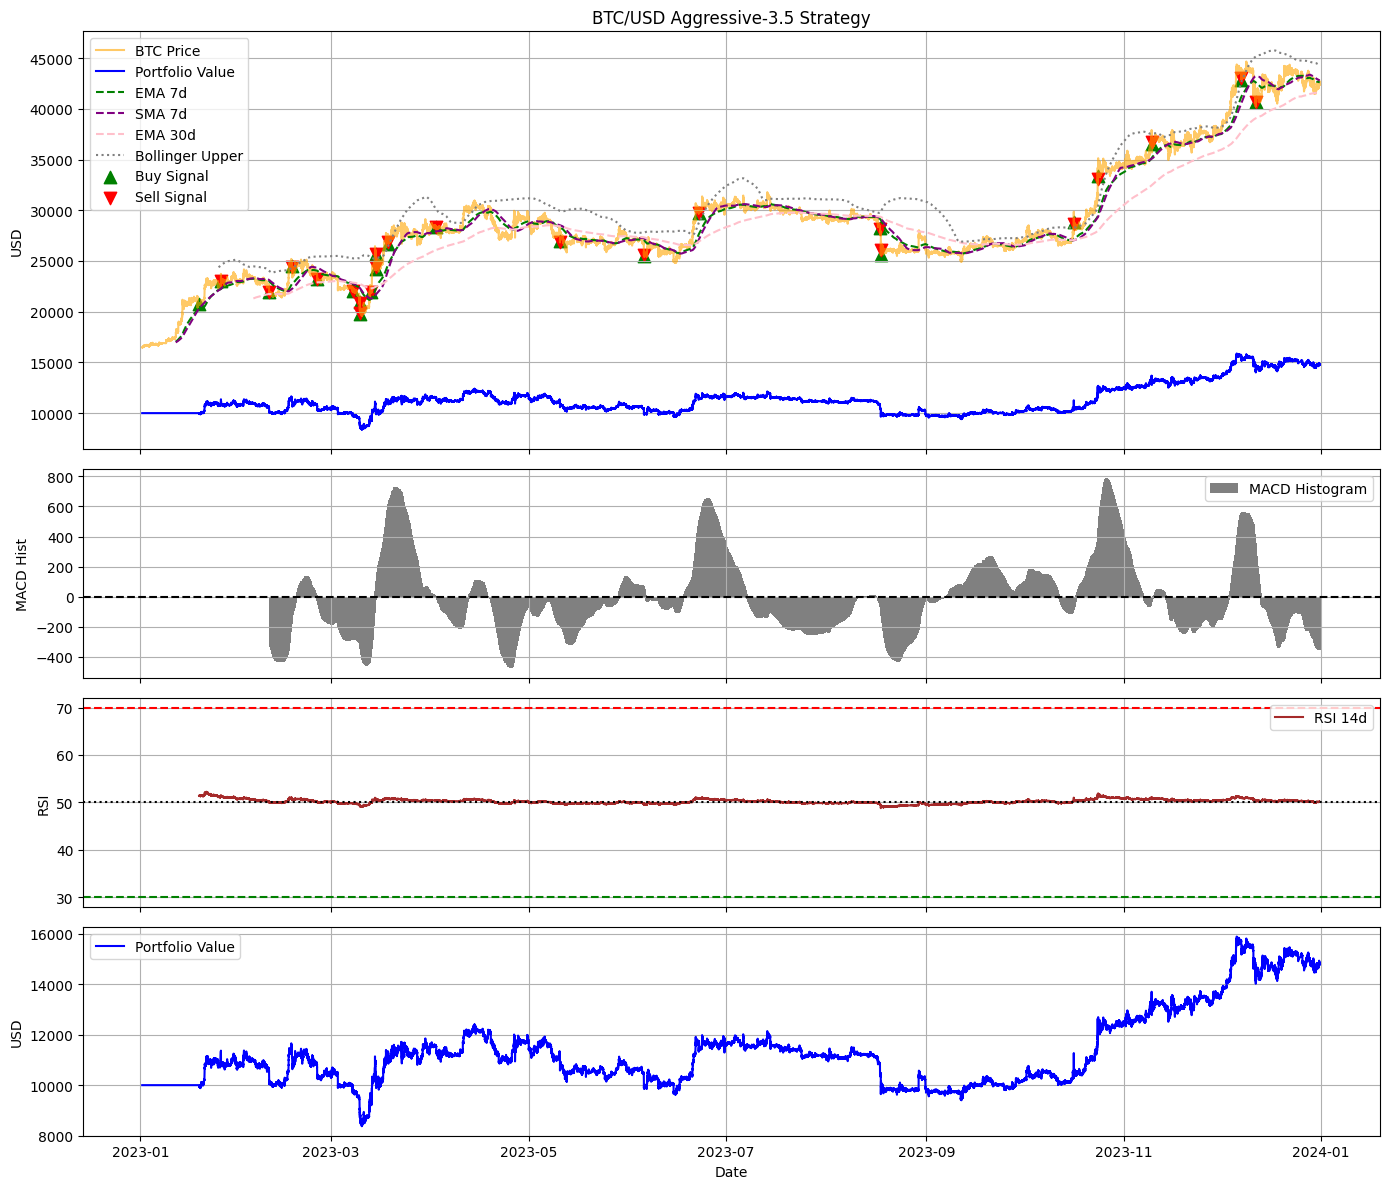

In [23]:
plot_full_strategy(df_v35, signals_v35, title = 'BTC/USD Aggressive-3.5 Strategy')

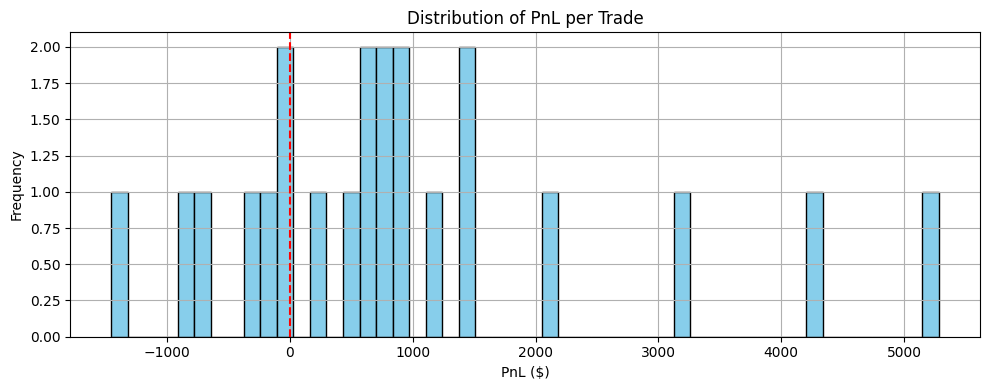

In [17]:
plt.figure(figsize=(10, 4))
plt.hist(trade_log_v35['PnL ($)'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of PnL per Trade')
plt.xlabel('PnL ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## v3.5 Comments & Analysis
### Thoughts & Concerns
#### Sharpe Ratio = 0.03:
- This implies low risk-adjusted return. Despite decent profit, the volatility in returns is high, suggesting inconsistent trade performance.

- A Sharpe ratio < 0.5 is generally considered poor for active strategies.

#### Win Rate = 50%:

- This alone isn’t bad if winners far exceed losers in magnitude, but:

- If combined with low Sharpe, it suggests the PnL distribution may be erratic, and losers might be wiping out winners to some extent.

#### Max Drawdown = -28.15%:

- This is high for a strategy that trades so infrequently.

- It signals exits might not be reactive enough, or stop-loss levels are too loose.
------------
### Further Steps
#### Tighten Entry Threshold

- This strategy tends to buy when the market satisfies any kinds of entry condition; as a result, it always buy quickly after it sold, and most likely before the market fully recoverd. Switch to 'and' instead of 'or'

- Add MACD histogram > 0 and raising (Tested: this condition is too strict, especially if we applied 'and')

#### Optimize RSI filter
- test RSI rolling window with shorter or longer period

#### Enhance Exit Threshold Reactiveness
- add several strong signal to 'or' condition, like MACD bearish signal (v3.7)

- add Stochastic Oscillator as indicators (v3.7)

#### Implement Position Sizing
- not all-in, using 50% as long-term, 50% as short-term (implement in v3.7)

- apply dynamic position sizing (implement in v4.0?)




In [27]:
def run_agg_strategy_v36(df, initial_cash=10000, hold_period=0, sl_pct=0.05, tp_pct=0.10,
                        trail_pct=0.03, fee_pct=0.0075, rsi_window=3):
    cash = initial_cash
    position = 0
    entry_price = 0
    hold_counter = 0
    portfolio = []
    signals = []
    trade_log = []
    in_trade = False
    peak_price = 0
    entry_time = None

    df['rsi_rolling_mean'] = df['rsi_14d'].rolling(window=rsi_window).mean()

    for i in range(2 + rsi_window, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]

        # Bull market regime filter
        is_bull_market = (
            row['Close'] > row['ema_30d'] and
            row['macd_hist_12_26'] > 0
        )

        ema_signal = row['ema_7d'] > row['sma_7d']
        macd_bullish = prev['macd_12_26'] < prev['macd_sig_12_26'] and row['macd_12_26'] > row['macd_sig_12_26']
        rsi_up = row['rsi_14d'] > row['rsi_rolling_mean']

        # Entry Logic
        if not in_trade and is_bull_market:
            if ema_signal or macd_bullish or rsi_up:
                entry_price = row['Close']
                position = (cash * (1 - fee_pct)) / entry_price
                entry_time = row.name
                hold_counter = 0
                peak_price = entry_price
                cash = 0
                in_trade = True
                signals.append((row.name, 'Buy', entry_price))

        # Exit Logic
        elif in_trade:
            hold_counter += 1
            price_change = (row['Close'] - entry_price) / entry_price
            peak_price = max(peak_price, row['Close'])
            trail_stop = (peak_price - row['Close']) / peak_price

            macd_bear = prev['macd_12_26'] > prev['macd_sig_12_26'] and row['macd_12_26'] < row['macd_sig_12_26']
            rsi_down = row['rsi_14d'] < row['rsi_rolling_mean']
            ema_reversal = row['ema_20d'] < row['sma_20d']
            fee_check = (row['Close'] - entry_price) > fee_pct * entry_price

            # Forced stop-loss (independent)
            stop_loss_hit = price_change <= -sl_pct
            # Trailing TP logic
            trail_exit = price_change >= tp_pct and trail_stop > trail_pct
            # Exit only if all are met
            exit_cond = all([macd_bear, rsi_down, ema_reversal, hold_counter >= hold_period, fee_check])

            if stop_loss_hit or trail_exit or exit_cond:
                exit_price = row['Close']
                exit_cash = position * exit_price * (1 - fee_pct)
                pnl = exit_cash - initial_cash
                return_pct = (exit_cash - initial_cash) / initial_cash * 100

                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Exit Time': row.name,
                    'Exit Price': round(exit_price, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Duration': hold_counter,
                    'Exit Type': 'Stop-Loss' if stop_loss_hit else 'Trailing TP' if trail_exit else 'Combined Exit'
                })

                cash = exit_cash
                position = 0
                in_trade = False
                signals.append((row.name, 'Sell', exit_price))

        total_value = cash if not in_trade else position * row['Close']
        portfolio.append(total_value)

    df_result = df.iloc[2 + rsi_window:].copy()
    df_result['portfolio_value'] = portfolio
    trade_log_df = pd.DataFrame(trade_log)
    return df_result, signals, trade_log_df

    return df_result, signals, trade_log_df


In [28]:
df_v36, signals_v36, trade_log_v36 = run_agg_strategy_v36(df)

summarize_portfolio(df_v36, signals_v36)

trade_log_v36.to_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/strategy/trade_log_agg_v36.csv', index=False)


Initial Capital          : $10,000.00
Final Portfolio Value    : $12,947.91
Net Profit               : $2,947.91
Total Return             : 29.48%
Number of Trades         : 13
Win Rate                 : 50.00%
Max Drawdown             : -17.78%
Sharpe Ratio             : 0.02


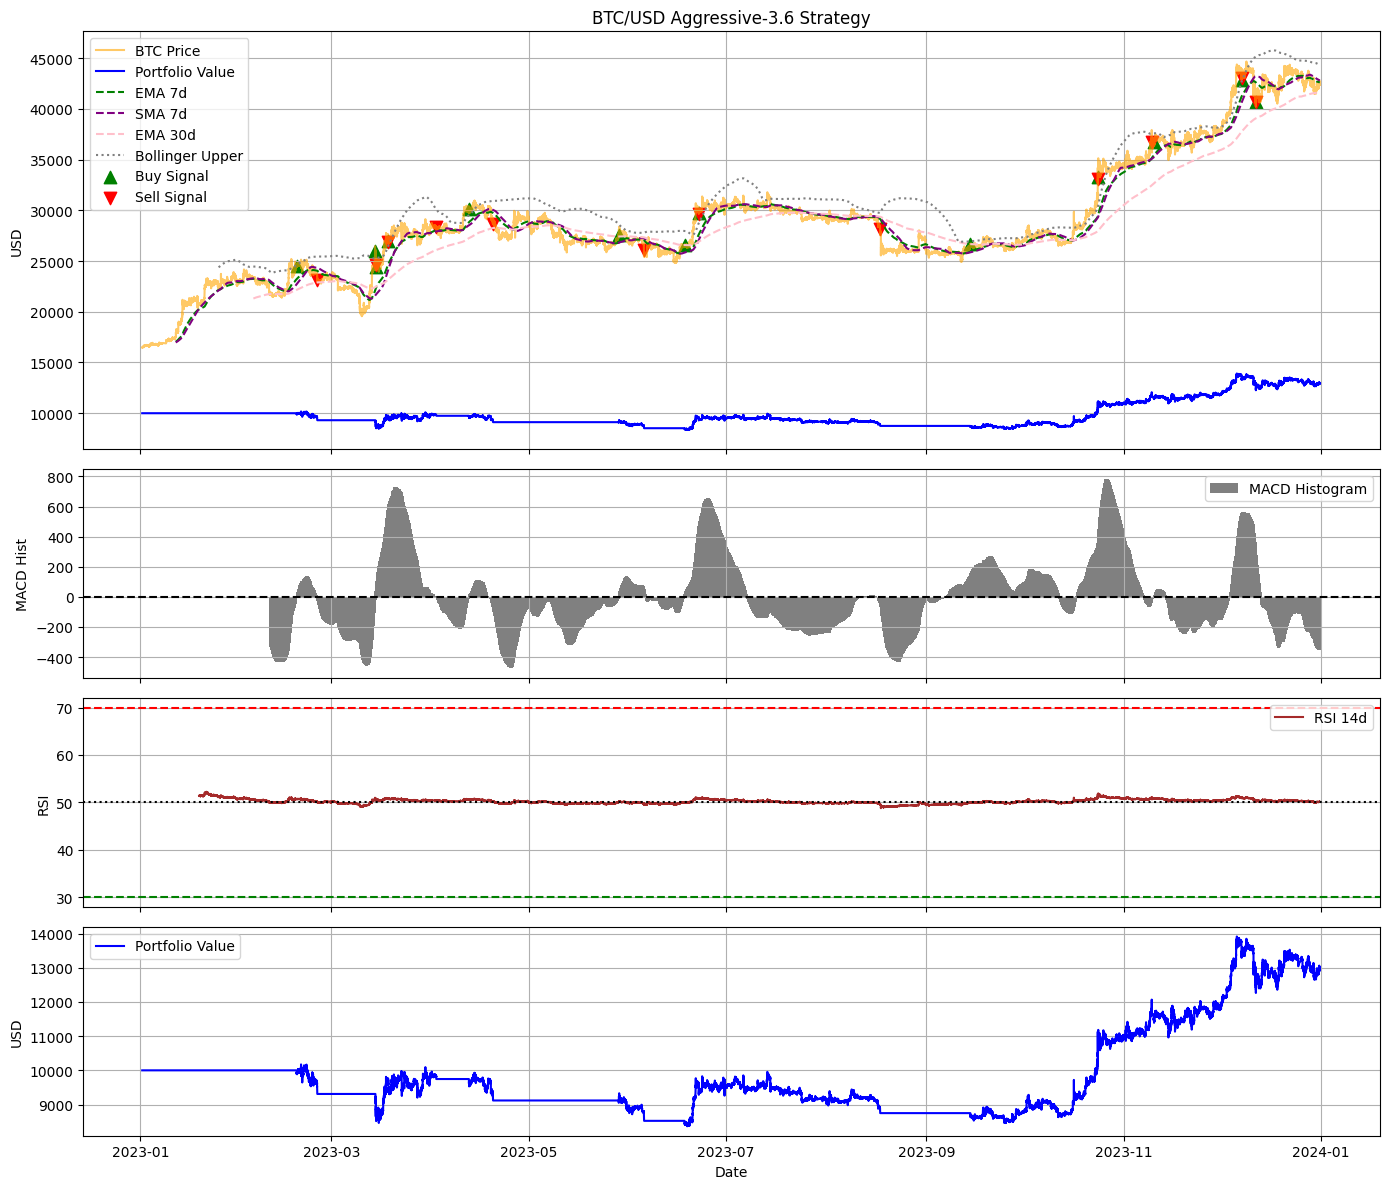

In [29]:
plot_full_strategy(df_v36, signals_v36, title = 'BTC/USD Aggressive-3.6 Strategy')

## Risk Comparison

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def compute_sortino_ratio(returns, rf_rate=0.0):
    downside = returns[returns < rf_rate]
    downside_std = np.std(downside)
    if downside_std == 0:
        return np.nan
    return (returns.mean() - rf_rate) / downside_std

def compute_var(returns, level=0.05):
    return np.percentile(returns, level * 100)

def compute_cvar(returns, level=0.05):
    var = compute_var(returns, level)
    return returns[returns <= var].mean()

def compute_profit_factor(trade_log):
    total_profit = trade_log[trade_log['PnL ($)'] > 0]['PnL ($)'].sum()
    total_loss = abs(trade_log[trade_log['PnL ($)'] < 0]['PnL ($)'].sum())
    return total_profit / total_loss if total_loss > 0 else np.nan

def compute_expectancy(trade_log):
    wins = trade_log[trade_log['PnL ($)'] > 0]['PnL ($)']
    losses = trade_log[trade_log['PnL ($)'] < 0]['PnL ($)']
    win_rate = len(wins) / len(trade_log)
    avg_win = wins.mean()
    avg_loss = abs(losses.mean())
    return (win_rate * avg_win) - ((1 - win_rate) * avg_loss)

def plot_trade_return_distribution(trade_log, label=''):
    sns.histplot(trade_log['Return (%)'], kde=True, bins=20)
    plt.title(f'Trade Return Distribution {label}')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='black', linestyle='--')
    plt.grid()
    plt.show()

def plot_duration_vs_return(trade_log, label=''):
    plt.scatter(trade_log['Duration'], trade_log['Return (%)'], alpha=0.6)
    plt.title(f'Trade Duration vs Return {label}')
    plt.xlabel('Duration (bars)')
    plt.ylabel('Return (%)')
    plt.grid()
    plt.show()

def plot_underwater(portfolio_series, label=''):
    rolling_max = portfolio_series.cummax()
    drawdown = (portfolio_series - rolling_max) / rolling_max
    plt.plot(drawdown, color='red')
    plt.title(f'Underwater Plot {label}')
    plt.ylabel('Drawdown (%)')
    plt.xlabel('Time')
    plt.grid()
    plt.show()


In [33]:
def run_risk_analysis(trade_log_df, portfolio_series, label=''):
    print(f'\n===== Risk Metrics Summary: {label} =====')
    
    returns = trade_log_df['Return (%)'] / 100.0
    sortino = compute_sortino_ratio(returns)
    var_95 = compute_var(returns, level=0.05)
    cvar_95 = compute_cvar(returns, level=0.05)
    profit_factor = compute_profit_factor(trade_log_df)
    expectancy = compute_expectancy(trade_log_df)
    
    print(f'Sortino Ratio        : {sortino:.4f}')
    print(f'95% VaR              : {var_95:.2%}')
    print(f'95% Conditional VaR  : {cvar_95:.2%}')
    print(f'Profit Factor        : {profit_factor:.2f}')
    print(f'Trade Expectancy ($) : {expectancy:.2f}')
    
    plot_trade_return_distribution(trade_log_df, label)
    plot_duration_vs_return(trade_log_df, label)
    plot_underwater(portfolio_series, label)



===== Risk Metrics Summary: v3.5 =====
Sortino Ratio        : 1.9843
95% VaR              : -8.55%
95% Conditional VaR  : -11.58%
Profit Factor        : 6.83
Trade Expectancy ($) : 942.78


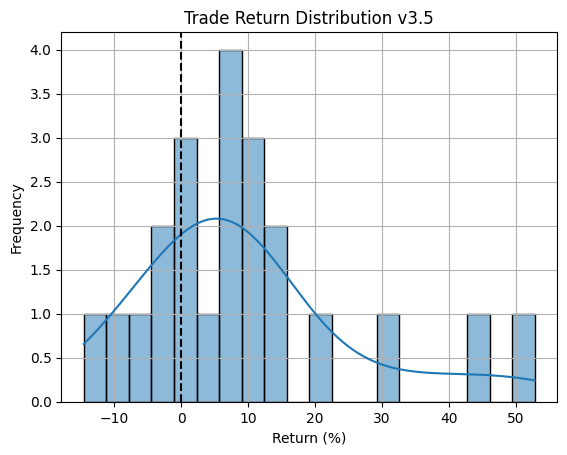

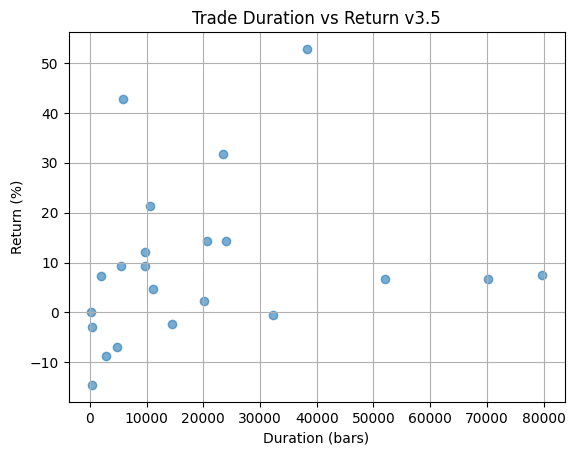

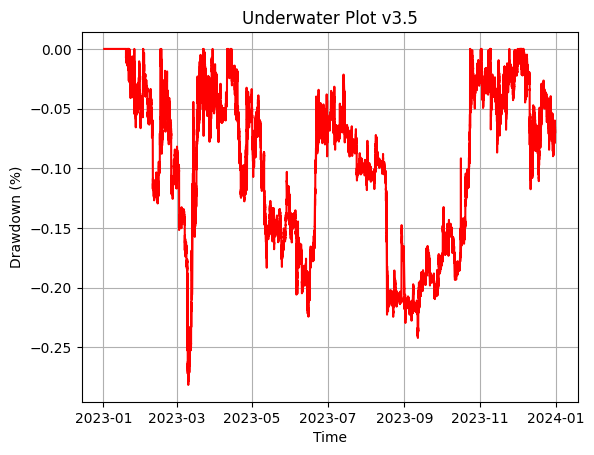


===== Risk Metrics Summary: v3.6 =====
Sortino Ratio        : 0.2417
95% VaR              : -13.80%
95% Conditional VaR  : -14.78%
Profit Factor        : 1.16
Trade Expectancy ($) : 96.20


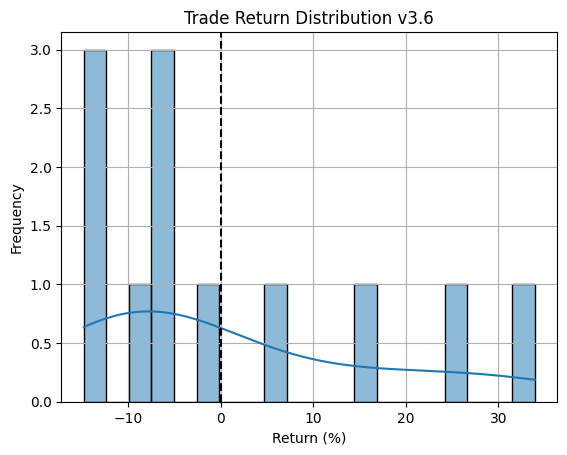

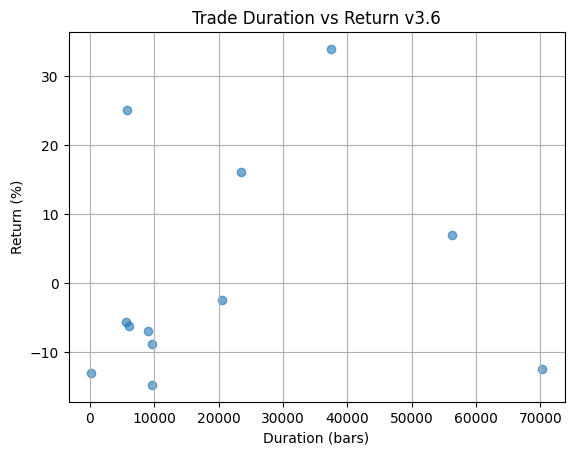

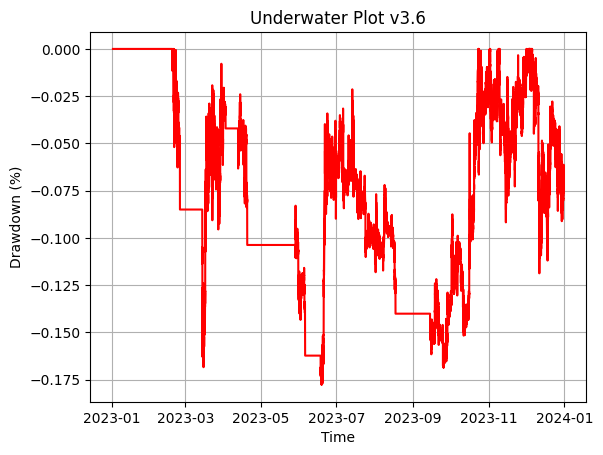

In [34]:
run_risk_analysis(trade_log_v35, df_v35['portfolio_value'], label='v3.5')
run_risk_analysis(trade_log_v36, df_v36['portfolio_value'], label='v3.6')
